In [20]:
import pandas as pd

In [21]:
# static files
map_file = '../ppi_ml/data/og_proteomes/nog_mapping/all.euNOG.diamond.mapping.2759'
leca_nog_file = '../ppi_ml/annotations/lists/leca_nogs.txt'
leca_slc_file = '../localization_ml/data/leca_slc.txt'
uniprot2slc_file = '../localization_ml/data/uniprotkb_sl2go.csv'

In [22]:
# theoretical args
species = 'human'
go_prot_file = f'../localization_ml/data/quickgo/{species}_qgo_all.tsv'
outfile_name = f'../localization_ml/results/leca_prop/{species}_leca_slc.csv'

In [23]:
def load_nog_data(leca_nog_file, nog_map_file):
    # load in orthology mapping data
    leca_nogs = [line.strip() for line in open(leca_nog_file, 'r')] # leca nogs
    print(f'total # of LECA OGs: {len(leca_nogs)}')
    all_nogs = pd.read_csv(nog_map_file, sep='\t')
    all_nogs['uniprot_ID'] = all_nogs['ProteinID'].str.extract('(?<=\|)(.*)(?=\|)', expand=False)
    return(leca_nogs, all_nogs)

def load_slc_data(leca_slc_file, slc_map_file):
    # load in localization data
    slc_list = [line.strip() for line in open(leca_slc_file, 'r')] # leca organelles
    up2slc = pd.read_csv(uniprot2slc_file) # slc terms to GO terms
    leca2slc = pd.DataFrame()
    leca2slc['leca_slc'] = slc_list
    # unmapped terms: "cytoplasmic granule" (SL-0281), "phagocytic cup" (SLC-0473)
    # these codes are on swiss bio pics not in master sl2go
    leca2slc = leca2slc.merge(up2slc, how='left', left_on='leca_slc', right_on='uniprot_term')
    return(leca2slc)
    
def map_leca_slc(go_file, leca2slc, all_nogs, leca_nogs):
    # map proteome and slc to orthogroups
    keep_cols = ['GENE PRODUCT ID','SYMBOL','QUALIFIER','GO TERM','GO NAME','GO ASPECT']
    df = pd.read_csv(go_file, sep='\t')
    df = df[keep_cols].drop_duplicates()
    df = df[df['GO TERM'].isin(leca2slc['go_code'])]
    df = df[df['GENE PRODUCT ID'].isin(all_nogs['uniprot_ID'])]
    nog_dict = dict(all_nogs[['uniprot_ID','ID']].values)
    df['ID'] = [nog_dict[i] for i in df['GENE PRODUCT ID']]
    # map orthogroups to leca nogs
    df['LECA'] = ['TRUE' if i in leca_nogs else 'FALSE' for i in df['ID']]
    # get true/false counts
    counts = df.groupby(['GO NAME','LECA']).size().to_frame().reset_index()
    counts = counts.rename(columns={0:'count'})
    return(counts)

In [24]:
species = ['human','arath','yeast','tetts','tryb2']
leca_nogs, all_nogs = load_nog_data(leca_nog_file, map_file)
leca2slc = load_slc_data(leca_slc_file, uniprot2slc_file)
for s in species:
    go_prot_file = f'../localization_ml/data/quickgo/{s}_qgo_all.tsv'
    outfile_name = f'../localization_ml/results/leca_prop/{s}_leca_slc.csv'
    leca_counts = map_leca_slc(go_prot_file, leca2slc, all_nogs, leca_nogs)
    print(f"total # of {s} LECA GO term assignments: {leca_counts['count'].sum()}")
    leca_counts['species'] = s
    leca_counts.to_csv(outfile_name, index=False)

total # of LECA OGs: 10092
total # of human LECA GO term assignments: 29875
total # of arath LECA GO term assignments: 16133
total # of yeast LECA GO term assignments: 7447
total # of tetts LECA GO term assignments: 1493
total # of tryb2 LECA GO term assignments: 7203


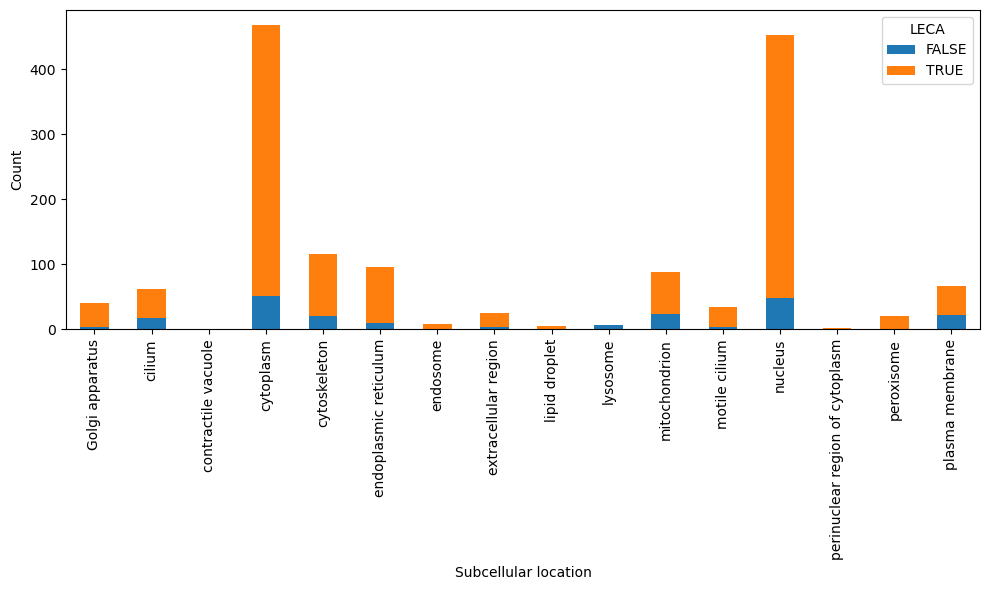

In [83]:
import matplotlib.pyplot as plt
# pivot the DataFrame to prepare for stacked bar plot
pivot_df = leca_counts.pivot(index='GO NAME', columns='LECA', values='count').fillna(0)

# create a stacked bar plot
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

# add labels and title
plt.xlabel('Subcellular location')
plt.ylabel('Count')

# Add legend
plt.legend(title='LECA', loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()

In [95]:
leca_counts[leca_counts['GO NAME']=='lipid droplet']

,GO NAME,LECA,count,species
24,lipid droplet,FALSE,1,tryb2
25,lipid droplet,TRUE,5,tryb2


In [93]:
leca2slc[leca2slc.leca_slc=='Lipid droplet']

,leca_slc,db,uniprot_code,uniprot_term,go_term,go_code
21,Lipid droplet,UniProtKB-SubCell,SL-0154,Lipid droplet,GO:lipid droplet,GO:0005811


In [87]:
leca2slc[leca2slc.go_code=='GO:0070062']

,leca_slc,db,uniprot_code,uniprot_term,go_term,go_code


In [90]:
up2slc[up2slc.uniprot_code=='SL-0466']

,db,uniprot_code,uniprot_term,go_term,go_code


In [28]:
leca2slc = load_slc_data(leca_slc_file, uniprot2slc_file)
cols = ['leca_slc','uniprot_code','go_term']
leca2slc[cols].to_csv("../localization_ml/data/leca2slc.csv", header=None, index=False)

In [29]:
leca2slc

,leca_slc,db,uniprot_code,uniprot_term,go_term,go_code
0,Cell membrane,UniProtKB-SubCell,SL-0039,Cell membrane,GO:plasma membrane,GO:0005886
1,Nucleus,UniProtKB-SubCell,SL-0191,Nucleus,GO:nucleus,GO:0005634
2,Endoplasmic reticulum,UniProtKB-SubCell,SL-0095,Endoplasmic reticulum,GO:endoplasmic reticulum,GO:0005783
3,Golgi apparatus,UniProtKB-SubCell,SL-0132,Golgi apparatus,GO:Golgi apparatus,GO:0005794
4,Endosome,UniProtKB-SubCell,SL-0101,Endosome,GO:endosome,GO:0005768
5,Mitochondrion,UniProtKB-SubCell,SL-0173,Mitochondrion,GO:mitochondrion,GO:0005739
6,Cytoskeleton,UniProtKB-SubCell,SL-0090,Cytoskeleton,GO:cytoskeleton,GO:0005856
7,Filopodium,UniProtKB-SubCell,SL-0286,Filopodium,GO:filopodium,GO:0030175
8,Pseudopodium,UniProtKB-SubCell,SL-0298,Pseudopodium,GO:pseudopodium,GO:0031143
9,Lamellipodium,UniProtKB-SubCell,SL-0291,Lamellipodium,GO:lamellipodium,GO:0030027


## Map all UniProt SLC OGs to LECA

In [5]:
import os
import re
from functools import reduce
import pandas as pd

In [6]:
nog_dir = '../localization_ml/data/uniprot_slc/nog_mapping/'
nog_files = [os.path.join(nog_dir, f) for f in os.listdir(nog_dir) if re.match('.*mapping$', f)]
leca_nog_file = '../ppi_ml/annotations/lists/leca_nogs.txt'
leca_nogs = [line.strip() for line in open(leca_nog_file, 'r')]
len(nog_files)

34

In [7]:
def map_leca(file, leca_nogs):
    # get slc label
    fname = os.path.basename(file)
    slc = fname.split('_SL-')[0]
    slc = slc.replace('_', ' ')
    # read & format data
    df = pd.read_csv(file, sep='\t')
    slc_ogs = set(df['ID'].to_list())
    # find intersection
    slc_leca = slc_ogs.intersection(set(leca_nogs))
    not_leca = len(slc_ogs) - len(slc_leca)
    # output results
    df['leca'] = [1 if i in slc_leca else 0 for i in df['ID']]
    df['entry'] = df['ProteinID'].str.extract('(?<=\|)(.*)(?=\|)', expand=False)
    df['slc'] = slc
    print(f'-------------- {slc} --------------')
    print(f'total # unique OGs = {len(slc_ogs)}')
    print(f'% in LECA = {round((len(slc_leca)/len(slc_ogs))*100, 2)}')
    return(df)

In [8]:
df_list = []
for f in nog_files:
    df = map_leca(f, leca_nogs)
    df_list.append(df)

-------------- Cilium --------------
total # unique OGs = 482
% in LECA = 61.83
-------------- Cell membrane --------------
total # unique OGs = 2862
% in LECA = 40.04
-------------- Cytoplasm --------------
total # unique OGs = 5225
% in LECA = 60.04
-------------- Lysosome --------------
total # unique OGs = 338
% in LECA = 69.23
-------------- Cytoskeleton --------------
total # unique OGs = 1317
% in LECA = 57.86
-------------- Endoplasmic reticulum --------------
total # unique OGs = 1398
% in LECA = 66.67
-------------- Golgi apparatus --------------
total # unique OGs = 1029
% in LECA = 65.99
-------------- Phagocytic cup --------------
total # unique OGs = 34
% in LECA = 85.29
-------------- Cytolytic granule --------------
total # unique OGs = 10
% in LECA = 70.0
-------------- Clathrin-coated pit --------------
total # unique OGs = 32
% in LECA = 87.5
-------------- Cell tip --------------
total # unique OGs = 31
% in LECA = 70.97
-------------- Flagellum --------------
total

In [9]:
df_out = pd.concat(df_list, ignore_index=True, sort=False)
df_out.to_csv("../localization_ml/results/uniprot_leca_slc.csv", index=False)
df_out

,ProteinID,ID,leca,entry,slc
0,sp|A0A096MJN4|SEPT4_RAT,KOG2655,1,A0A096MJN4,Cilium
1,sp|A0A0R4IVA4|CC14A_DANRE,KOG1720,1,A0A0R4IVA4,Cilium
2,sp|A0A0U1RPR8|GUC2D_MOUSE,KOG1023,1,A0A0U1RPR8,Cilium
3,sp|A0A1C3NSL9|AJM1_CAEEL,ENOG502QUPQ,0,A0A1C3NSL9,Cilium
4,sp|A0A2I0BVG8|CDPK1_PLAFO,KOG0032,1,A0A2I0BVG8,Cilium
...,...,...,...,...,...
177064,sp|Q5AHB1|PAN1_CANAL,KOG1029,1,Q5AHB1,Endosome
177065,sp|Q10122|SORF2_CAEEL,KOG4435,1,Q10122,Endosome
177066,sp|Q5S007|LRRK2_HUMAN,KOG0619,1,Q5S007,Endosome
177067,sp|Q9FY48|KEG_ARATH,KOG4185,1,Q9FY48,Endosome


In [15]:
file = '../localization_ml/data/uniprot_slc/nog_mapping/autophagosome_SL_0023.diamond.emapper.mapping'
leca_nog_file = '../ppi_ml/annotations/lists/leca_nogs.txt'
leca_nogs = [line.strip() for line in open(leca_nog_file, 'r')]
df = pd.read_csv(file, sep='\t')
slc_ogs = set(df['ID'].to_list())
slc_leca = slc_ogs.intersection(set(leca_nogs))
not_leca = len(slc_ogs) - len(slc_leca)
print(f'total # unique OGs = {len(slc_ogs)}')
print(f'% in LECA = {round((len(slc_leca)/len(slc_ogs))*100, 2)}')

total # unique OGs = 80
% in LECA = 72.5


In [16]:
file = '../localization_ml/data/uniprot_slc/nog_mapping/phagosome_SL_0206.diamond.emapper.mapping'
leca_nog_file = '../ppi_ml/annotations/lists/leca_nogs.txt'
leca_nogs = [line.strip() for line in open(leca_nog_file, 'r')]
df = pd.read_csv(file, sep='\t')
slc_ogs = set(df['ID'].to_list())
slc_leca = slc_ogs.intersection(set(leca_nogs))
not_leca = len(slc_ogs) - len(slc_leca)
print(f'total # unique OGs = {len(slc_ogs)}')
print(f'% in LECA = {round((len(slc_leca)/len(slc_ogs))*100, 2)}')

total # unique OGs = 65
% in LECA = 87.69


In [17]:
file = '../localization_ml/data/uniprot_slc/nog_mapping/cyto_granule_SL_0281.diamond.emapper.mapping'
leca_nogs = [line.strip() for line in open(leca_nog_file, 'r')]
df = pd.read_csv(file, sep='\t')
slc_ogs = set(df['ID'].to_list())
slc_leca = slc_ogs.intersection(set(leca_nogs))
not_leca = len(slc_ogs) - len(slc_leca)
print(f'total # unique OGs = {len(slc_ogs)}')
print(f'% in LECA = {round((len(slc_leca)/len(slc_ogs))*100, 2)}')

total # unique OGs = 130
% in LECA = 63.85


In [18]:
file = '../localization_ml/data/uniprot_slc/nog_mapping/filopodium_SL_0286.diamond.emapper.mapping'
leca_nogs = [line.strip() for line in open(leca_nog_file, 'r')]
df = pd.read_csv(file, sep='\t')
slc_ogs = set(df['ID'].to_list())
slc_leca = slc_ogs.intersection(set(leca_nogs))
not_leca = len(slc_ogs) - len(slc_leca)
print(f'total # unique OGs = {len(slc_ogs)}')
print(f'% in LECA = {round((len(slc_leca)/len(slc_ogs))*100, 2)}')

total # unique OGs = 67
% in LECA = 76.12
